## 0. 구글 드라이브 연결 및 필수 라이브러리 설치 및 로드

### 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### 필수 라이브러리 설치 및 로드

In [2]:
#!pip install nltk

In [3]:
#!pip install konlpy

In [4]:
#from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import nltk
import re

from keras.callbacks import *
import os
import tensorflow as tf

In [5]:
#nltk.download()

# 이거 안하면 lookuperror 뜬다.(필요한 것만 지정해서 다운로드 해도되고, all을 사용하여 모두 다운로드 해도 된다.)

In [6]:
# 이후에 데이터 및 파일들을 저장할 경로를 path로 통일하여 따로 저장

path = '/content/gdrive/MyDrive/Colab Notebooks/CUAI 하계프로젝트-NLP/초기 모델링 진행/data/'

***여기 이후부터는 완료된 단계(4. 토큰화, 5. 정수 인코딩 등)로 점프해서 실행시키면 됨!!(노트북을 나누면서 앞부분 삭제함)***

## 6. GPT2 모델링

### 6-1. GPT2 모델링에 필요한 모듈 및 함수 import  

앞선 단계에서 토큰화, 정수 인코딩, 패딩, 워드 임베딩을 수행했으나   
GPT2 모델링에 참고한 책 **"텐서플로 2와 머신러닝으로 시작하는 자연어 처리"**를 보니(p.516) 기존에 한 것과 아예 다른 토크나이저를 사용하기 때문에 모델의 입력 데이터를 구성하는 방식이 다르다고 함  
따라서 책에 있는 코드를 따라가며 GPT2 모델링에 필요한 모듈 및 함수 import하였음

In [7]:
!pip install gluonnlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 4.8 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595752 sha256=38f1dbce0f2e332103be47384681c35e7d141c2fc1c81ea7706120e708299676
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


In [8]:
!pip install mxnet 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 163 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.7 MB/s 
     |████████████████████████████████| 101 kB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 59.9 MB/s 
     |████████████████████████████████| 596 kB 75.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [10]:
# 모델 학습에 필요한 3개의 모듈 import

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from transformers import *

In [11]:
# 불러온 모델을 활용해 여기서 사용할 모델 클래스를 구현
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [12]:
! pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=9f70d4f76fb69ee67812d81e0a4e3f6743d5db38d4ad6d66e42c9881bbc0f24d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [13]:
# 구현된 모델 클래스에 학습된 파라미터를 다운로드
import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')
with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

In [14]:
# 학습된 파라미터를 다운로드 받았다면 다음과 같은 경로로 파라미터를 이동시킨 후 모델을 선언
# 경로에는 반드시 config.json과 tf.model.h5 파일이 있어야 함
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

loading configuration file ./gpt_ckpt/config.json
Model config GPT2Config {
  "activation_function": "gelu",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.21.1",
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ./gpt_ckpt/tf_model.h5
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model c

### 6-2. final_data를 train/test로 나눈 후 train 데이터 전처리

In [37]:
# 후에 나올 주요 변수들 정의
MAX_LEN = 25 # okt 형태소 분석기로 분석했을 때 95%의 데이터들이 살아남은 지점의 길이
NUM_EPOCHS = 5 # 임의로 설정
BATCH_SIZE = 256 # 임의로 설정
VALID_SPLIT = 0.1 # 임의로 설정

In [16]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.9 MB/s 


In [17]:
# 데이터를 불러오기에 앞서 먼저 토크나이저를 생성
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'
tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=-1) # 여기서 num_best를 반드시 설정해줘야 밑에서 오류 안남
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH, 
                                               mask_token=None, 
                                               sep_token='<unused0>', 
                                               cls_token=None, 
                                               unknown_token='<unk>',  
                                               padding_token='<pad>', 
                                               bos_token='<s>', 
                                               eos_token='</s>')

|스페셜 토큰|역할|
|-------|--------|
| unused0 |SEP 토큰으로 두 개의 문장을 입력할 때 문장을 구분해 주는 토큰으로 활용  
||(자연어 추론과 텍스트 유사도 모델에서 활용 예정)|

In [18]:
# 이제 final_data 로드
# (참고)path 부분은 맨 앞 0장의 마지막 코드에서 경로 지정하였음!

data = pd.read_excel(path + 'final_data.xlsx', engine='openpyxl')

In [19]:
data.tail(3)

,Unnamed: 0,document,label
293103,293103,당장 내일 밥은 어떡하고 내 병원비는 어쩌지,0
293104,293104,응 이제 다들 독립해가지고 명절 아니면 찾아오질 않아,0
293105,293105,안부전화라도 해주면 좋을 텐데,0


In [20]:
# 책에 train과 test 데이터를 나눴으므로 train_test_split을 이용해 final_data를 분리(랜덤 시드 42로 고정)
train_data, test_data = train_test_split(data, test_size = 0.25, shuffle=True, 
                                         stratify = data['label'], random_state=42)

In [21]:
# 이 부분은 만일을 위해 따로 텍스트 파일로 저장해 둔 것
# train/test 데이터가 새로 바뀔 때만 이 코드 실행하는 걸 추천

#train_data.to_csv(path + 'final_train_data_0.75.txt', sep = '\t', index = False)
#test_data.to_csv(path + 'final_test_data_0.25.txt', sep = '\t', index = False)

In [22]:
# 이제 train 데이터로 토크나이저를 활용해 모델에 입력할 데이터를 구성
train_data_sents = []
train_data_labels = []

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

for train_sent, train_label in train_data[['document', 'label']].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))] 
    # 위 코드 우측 부분이 책에는 clean_text(train_sent)로 되어있었으나 검색해보니
    # clean_text가 불필요한 문자 제거 그런거여서 이미 정제된 상태이므로 그냥 train_sent로 작성함

    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([train_tokenized_text], 
                            maxlen=MAX_LEN, # 앞에 6-2에서 정함
                            value=vocab[vocab.padding_token], 
                            padding='pre').tolist()[0]
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

### 6-3. final_train_data를 모델에 학습시키기

민기가 사용했다는 gpu 추가 사용하는 거 코드 추가함

In [23]:
# GPU를 사용한 TensorFlow로 GPU 디바이스 확인
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


그리고 아래에서 학습과 평가 시 진행률을 좀 더 잘 보기 위해 tqdm 사용하는거 코드도 추가함

In [24]:
# 라이브러리 import
from tqdm import tqdm
import time

for i in tqdm(data):
    time.sleep(0.5)

# pip 설치 반드시 하기(코랩 포함)
!pip install -U tensorflow-addons

import tensorflow_addons as tfa

tqdm_callback = tfa.callbacks.TQDMProgressBar()

  0%|          | 3/293106 [00:01<40:53:55,  1.99it/s]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [25]:
# 모델 학습에 앞서 GPT2 텍스트 분류기를 만들기 위해 TFGPT2Classifier라는 클래스를 정의
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class

        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        gpt_output =outputs[0][:, -1]

        pooled_output = self.dropout(gpt_output)
        logits = self.classifier(pooled_output)

        return logits

In [26]:
# 분류기 모델을 학습하는 방법은 책에 앞서 등장했던 BERT나 GPT1의 학습 방법과 동일하다고 함
# 먼저 분류기 모델을 생성하고 최적화 함수와 손실 함수, 평가에 활용할 정확도 함수를 구성해 model.compile을 실행하면
# 모델을 학습할 준비가 끝남
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

loading configuration file ./gpt_ckpt/config.json
Model config GPT2Config {
  "activation_function": "gelu",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.21.1",
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ./gpt_ckpt/tf_model.h5
All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at

In [38]:
# 학습을 진행할 때는 GPU로 학습하는 것을 권장한다고 함(그래서 처음 코드 실행할 때부터 런타임:GPU로 해놓았음)
model_name = 'tf2_gpt2_mark4'

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

# 이부분 경로는 일단 그냥 구글드라이브의 data 모아놨던 곳으로 코드 바꿈
checkpoint_path = os.path.join(path, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else: 
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor="val_accuracy", 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True, 
)

with tf.device('/device:GPU:0'):
    history = cls_model.fit(
        train_data_sents, 
        train_data_labels, 
        epochs=NUM_EPOCHS, # 앞에 6-2에서 정함
        batch_size=BATCH_SIZE, # 앞에 6-2에서 정함 
        validation_split=VALID_SPLIT, # 앞에 6-2에서 정함
        callbacks=[earlystop_callback, cp_callback, tqdm_callback] 
    )

/content/gdrive/MyDrive/Colab Notebooks/CUAI 하계프로젝트-NLP/초기 모델링 진행/data/tf2_gpt2_mark4 -- Folder create complete 



Training:   0%|           0/5 ETA: ?s,  ?epochs/s

Epoch 1/5


0/773           ETA: ?s - 

Epoch 1/5
773/773 [==============================] - ETA: 0s - loss: 0.2530 - accuracy: 0.8958
Epoch 1: val_accuracy improved from -inf to 0.87645, saving model to /content/gdrive/MyDrive/Colab Notebooks/CUAI 하계프로젝트-NLP/초기 모델링 진행/data/tf2_gpt2_mark4/weights.h5
773/773 [==============================] - 1071s 1s/step - loss: 0.2530 - accuracy: 0.8958 - val_loss: 0.3036 - val_accuracy: 0.8765
Epoch 2/5


0/773           ETA: ?s - 

Epoch 2/5
773/773 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9069
Epoch 2: val_accuracy improved from 0.87645 to 0.87959, saving model to /content/gdrive/MyDrive/Colab Notebooks/CUAI 하계프로젝트-NLP/초기 모델링 진행/data/tf2_gpt2_mark4/weights.h5
773/773 [==============================] - 1075s 1s/step - loss: 0.2293 - accuracy: 0.9069 - val_loss: 0.3125 - val_accuracy: 0.8796
Epoch 3/5


0/773           ETA: ?s - 

Epoch 3/5
773/773 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9170
Epoch 3: val_accuracy did not improve from 0.87959
773/773 [==============================] - 1072s 1s/step - loss: 0.2073 - accuracy: 0.9170 - val_loss: 0.3246 - val_accuracy: 0.8771
Epoch 4/5


0/773           ETA: ?s - 

Epoch 4/5
773/773 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9266
Epoch 4: val_accuracy did not improve from 0.87959
773/773 [==============================] - 1074s 1s/step - loss: 0.1847 - accuracy: 0.9266 - val_loss: 0.3508 - val_accuracy: 0.8775


위에서 cls_model.fit() 실행 시 각 Epoch 당 약 17분 정도의 시간이 소요됨(런타임: GPU로 설정 기준)  
무슨 이유에선지 네 번째 Epoch 까지만 돌아가고 학습이 멈추었음
- 첫 번째 Epoch의 accuracy: 89.58%
- 두 번째 Epoch의 accuracy: 90.69%
- 세 번째 Epoch의 accuracy: 91.70%
- 네 번째 Epoch의 accuracy: 92.66%

In [39]:
# 앞에서 numpy array로 변환 실패해서 오류 뜬게 결국 문제가 됨
# 그 이전 코드에서 maxlen을 특정 숫자로 설정해주니까 드디어 실행됨

# accuracy와 loss를 그래프로 나타내기 위한 함수 정의
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

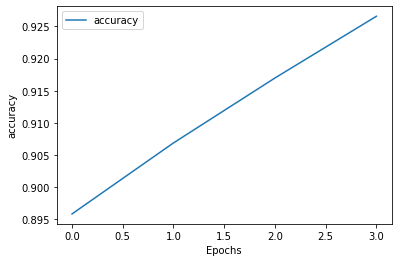

In [40]:
plot_graphs(history, 'accuracy')

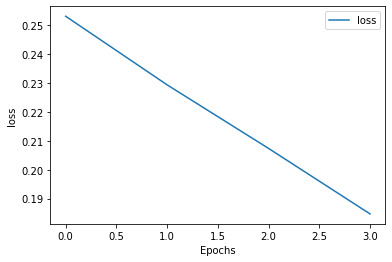

In [41]:
plot_graphs(history, 'loss')

### 6-4. final_test_data로 모델의 성능 테스트하기

In [42]:
# 이제 test 데이터로 테스트를 진행
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
    test_tokenized_text = vocab[tokenizer(test_sent)] 
    # 위 코드 역시 우측 부분이 책에는 clean_text(test_sent)로 되어있었으나 검색해보니
    # clean_text가 불필요한 문자 제거 그런거여서 이미 정제된 상태이므로 그냥 test_sent로 작성함

    tokens = [vocab[vocab.bos_token]]
    tokens += pad_sequences([test_tokenized_text], 
                            maxlen=MAX_LEN, # 앞에 6-2에서 정함 
                            value=vocab[vocab.padding_token], 
                            padding='pre').tolist()[0]
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

In [43]:
test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [44]:
# 다음 코드에서 load_weights에 대응하는 save-weights 코드가 없어 직접 짬
cls_model.save_weights(checkpoint_path)

In [45]:
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate(
    test_data_sents, 
    test_data_labels, 
    batch_size=BATCH_SIZE,
    callbacks=[tqdm_callback]
) # 책은 batch_size=1024 였음

0/287           ETA: ?s - Evaluating

287/287 [==============================] - 133s 462ms/step - loss: 0.3445 - accuracy: 0.8784


test_data에 모델을 테스트해본 결과 accuracy가 87.84%로 이전 mark1에서 epoch=3 때(88.01%)보다는 조금 낮지만 mark2에서 epoch=5 때랑 mark3에서 batch_size=256 때보다는 accuracy가 높았음  


In [46]:
# 궁금해서 test의 batch_size를 키워보았음
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate(
    test_data_sents, 
    test_data_labels, 
    batch_size=1024,
    callbacks=[tqdm_callback]
)

0/72           ETA: ?s - Evaluating

72/72 [==============================] - 131s 2s/step - loss: 0.3445 - accuracy: 0.8784


In [47]:
# 궁금해서 test의 batch_size를 줄여보았음
cls_model.load_weights(checkpoint_path)

results = cls_model.evaluate(
    test_data_sents, 
    test_data_labels, 
    batch_size=64,
    callbacks=[tqdm_callback]
)

0/1145           ETA: ?s - Evaluating

1145/1145 [==============================] - 138s 120ms/step - loss: 0.3445 - accuracy: 0.8784


test_data의 batch_size는 달라져도 accuracy가 달라지지 않는다는 것을 알 수 있었음

# END